# Analysis of TES Data
## Using feature reduction and clustering
One script to rule them all!

In [1]:
# import libraries
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
import pyperclip
import datetime
import cupy as cp

from readTrc import Trc
from scipy import signal
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn import manifold

%matplotlib notebook

# Load data

In [3]:
# This is the directory for the data for the anabsalysis
data_dir            = './SECONDTHORIUM/DCR_14072023_Lito2_E20_and_Lito2_B20_thorium/'
channels            = ['C1','C2','C3','C4']

# Load the data per channel
filenames           = {channel: [file for file in os.listdir(data_dir) if channel in file] for channel in channels}
# Dont forget to sort them so that coincidences will match up correctly
for channel in channels:
    filenames[channel]=np.sort(filenames[channel])
    
# Load the data
trc_loader          = Trc()   # Create a loader object
traces              = {channel: [trc_loader.open(os.path.join(data_dir,filename)) for filename in filenames[channel]] for channel in channels}
#Implement time cuts
starttime=datetime.datetime(2023,7,14, 15,54) #second throium
endtime=datetime.datetime(2023,7,15, 9,32) #second throium

# oscilloscope_offset=datetime.timedelta(minutes=44)
# starttime=datetime.datetime(2023,7,6,18,46,16)+oscilloscope_offset ##times for initial run
# endtime=datetime.datetime(2023,7,7, 7,30,15)+oscilloscope_offset ##times for initial run
#starttime=datetime.datetime(2023,7,7,19,28,1) ##times for weeked run
#endtime=datetime.datetime(2023,7,8,7,5,51)##times for weeked run

intimetraces={channel:[] for channel in channels}
for channel in channels:
    for trace in traces[channel]:
        if (trace[2]['TRIGGER_TIME']<endtime and trace[2]['TRIGGER_TIME']>starttime):
            intimetraces[channel].append(trace)     
traces=intimetraces

# Load the Reference Pulses
reference_pulses    = pd.read_csv('./DATA/REFERENCE/reference.dat', skiprows=5, header=[0,1], sep='\t')

In [4]:
print(filenames['C2'][1])

C2--DCR_thorium_Lito2_E20_tr51mV_8p1uA_Lito2_B20_tr45mV_7p66uA_43mK_nofilter--00001.trc


In [5]:
print(len(traces['C1']))
#print((traces['C3'][-1][2]['TRIGGER_TIME']))

print(len(traces['C2']))

2324
2324


In [6]:
print(reference_pulses)

          time Amp_1ph_0.8eV Amp_2ph_1.6eV Amp_3ph_2.4eV
             s             V             V             V
0    -0.000012      0.000113      0.000325      0.000302
1    -0.000012     -0.000279     -0.000180     -0.000043
2    -0.000012      0.000170      0.000307      0.000390
3    -0.000012      0.000022      0.000227      0.000295
4    -0.000011      0.000068      0.000210      0.000158
...        ...           ...           ...           ...
2495  0.000088      0.000119      0.000405      0.000287
2496  0.000088      0.000165      0.000386      0.000461
2497  0.000088     -0.000291     -0.000029     -0.000028
2498  0.000088      0.000088      0.000442      0.000579
2499  0.000088      0.000067      0.000252      0.000468

[2500 rows x 4 columns]


# Oscilloscope Parameters

In [7]:
# The settings of the oscilloscope
CHANNEL             = channels[1]
REFERENCE_VOLTAGE   = signal.resample(reference_pulses['Amp_2ph_1.6eV'].to_numpy().T[0],len(traces[CHANNEL][0][0]))

# Filter the traces


In [8]:
# Select the traces that had nonzero signal
mask_tes        = [np.min(data[1]) < -0.052 for data in traces[CHANNEL]] #0.052
idx_tes         = np.where(np.array(mask_tes))[0]
traces_filtered = [traces[CHANNEL][i] for i in idx_tes]

# Note Number of Multicoincidence

In [9]:
SECONDTES            = channels[0]
mask_second       = [np.min(data[1]) < -0.052 for data in traces[SECONDTES]]
SCINT            = channels[2]
mask_scint       = [np.min(data[1]) < -0.02 for data in traces[SCINT]]
SCINT2            = channels[3]
mask_scint2       = [np.min(data[1]) < -0.02 for data in traces[SCINT2]]

In [10]:
mask_coinc=[(mask_tes[i] and mask_second[i]) for i in range(0,len(mask_tes))]

In [11]:
print(np.unique(mask_tes,return_counts=True))
print(np.unique(mask_second,return_counts=True))
print(np.unique(mask_scint,return_counts=True))
print(np.unique(mask_scint2,return_counts=True))
print(np.unique(mask_coinc, return_counts=True))

(array([False,  True]), array([1466,  858]))
(array([False,  True]), array([ 874, 1450]))
(array([], dtype=float64), array([], dtype=int64))
(array([], dtype=float64), array([], dtype=int64))
(array([False,  True]), array([2285,   39]))


In [12]:
# idx_third         = np.where(np.array(mask_bottom))[0]
# print(idx_third)
traces_filtered = [traces[CHANNEL][i] for i in idx_tes]
othertes_filtered=[traces[SECONDTES][i] for i in idx_tes]

In [14]:
idx_coinc         = np.where(np.array(mask_coinc))[0]
print(list(idx_coinc))

[4, 15, 25, 33, 206, 246, 329, 418, 455, 499, 623, 655, 714, 785, 821, 901, 987, 1261, 1346, 1399, 1564, 1579, 1686, 1738, 1777, 1858, 1889, 1925, 1926, 2032, 2096, 2111, 2174, 2188, 2213, 2214, 2277, 2307, 2323]


# Useful Functions

In [15]:
def plot_signal(voltage,fig=None,ax=None,order=2,mysize=1/50,**kwargs):
    '''
    Returns a Pyplot figure of the smoothed voltage signal as a function of
    event number
    '''
    #butterybiscuits=signal.wiener(voltage,mysize=11)
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,voltage)
    
    if fig is None: fig = plt.figure()
    if ax is None: ax  = fig.add_subplot(111)
    
    ax.plot(butterybiscuits,**kwargs)
    
    return fig,ax

In [16]:
def values_raw(time,data,order=2,mysize=1/50):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak        = np.argmin(butterybiscuits)
    area        = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1])) 
    #area_mod    =np.sum(butterybiscuits[:-1])*(time[-1]-time[1])) 
    peakheight  = np.min(butterybiscuits)
    halfheights = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm        = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    medheight   = np.median(butterybiscuits)
    meanheight  = np.mean(butterybiscuits)
    meantime    = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std         = np.std(butterybiscuits)
    grad        = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min    = np.mean(grad[np.where(grad<0)])
    grad_max    = np.mean(grad[np.where(grad>0)])
    corr        = signal.correlate(data/np.min(data)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    
    
    return area,peakheight

def values_of_interest(time,data,order=2,mysize=1/50):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak        = np.argmin(butterybiscuits)
    area        = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    peakheight  = np.min(butterybiscuits)
    halfheights = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm        = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    medheight   = np.median(butterybiscuits)
    meanheight  = np.mean(butterybiscuits)
    meantime    = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std         = np.std(butterybiscuits)
    grad        = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min    = np.mean(grad[np.where(grad<0)])
    grad_max    = np.mean(grad[np.where(grad>0)])
    corr        = signal.correlate(data/np.min(data)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    
    
    return (fwhm/peakheight,(meantime-time[peak])/peakheight,std/area, np.sqrt(np.mean(grad**2)),grad_min,grad_max,np.max(corr))

# Feature Reduction

In [17]:
# Get the data for each of the pulses
values      = cp.array([values_of_interest(*data[:2],order=1,mysize=1/300) for data in tqdm(traces_filtered)])

# Center data
mu          = cp.tile(np.mean(values,axis=0),len(values)).reshape(values.shape)
X_centered  = (values-mu)
X_centered  = X_centered / cp.tile(np.max(X_centered,axis=0)-cp.min(X_centered,axis=0),len(X_centered)).reshape(X_centered.shape)

# Single Value Decomposition
u,s,vT      = cp.linalg.svd(X_centered)

  0%|          | 0/858 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


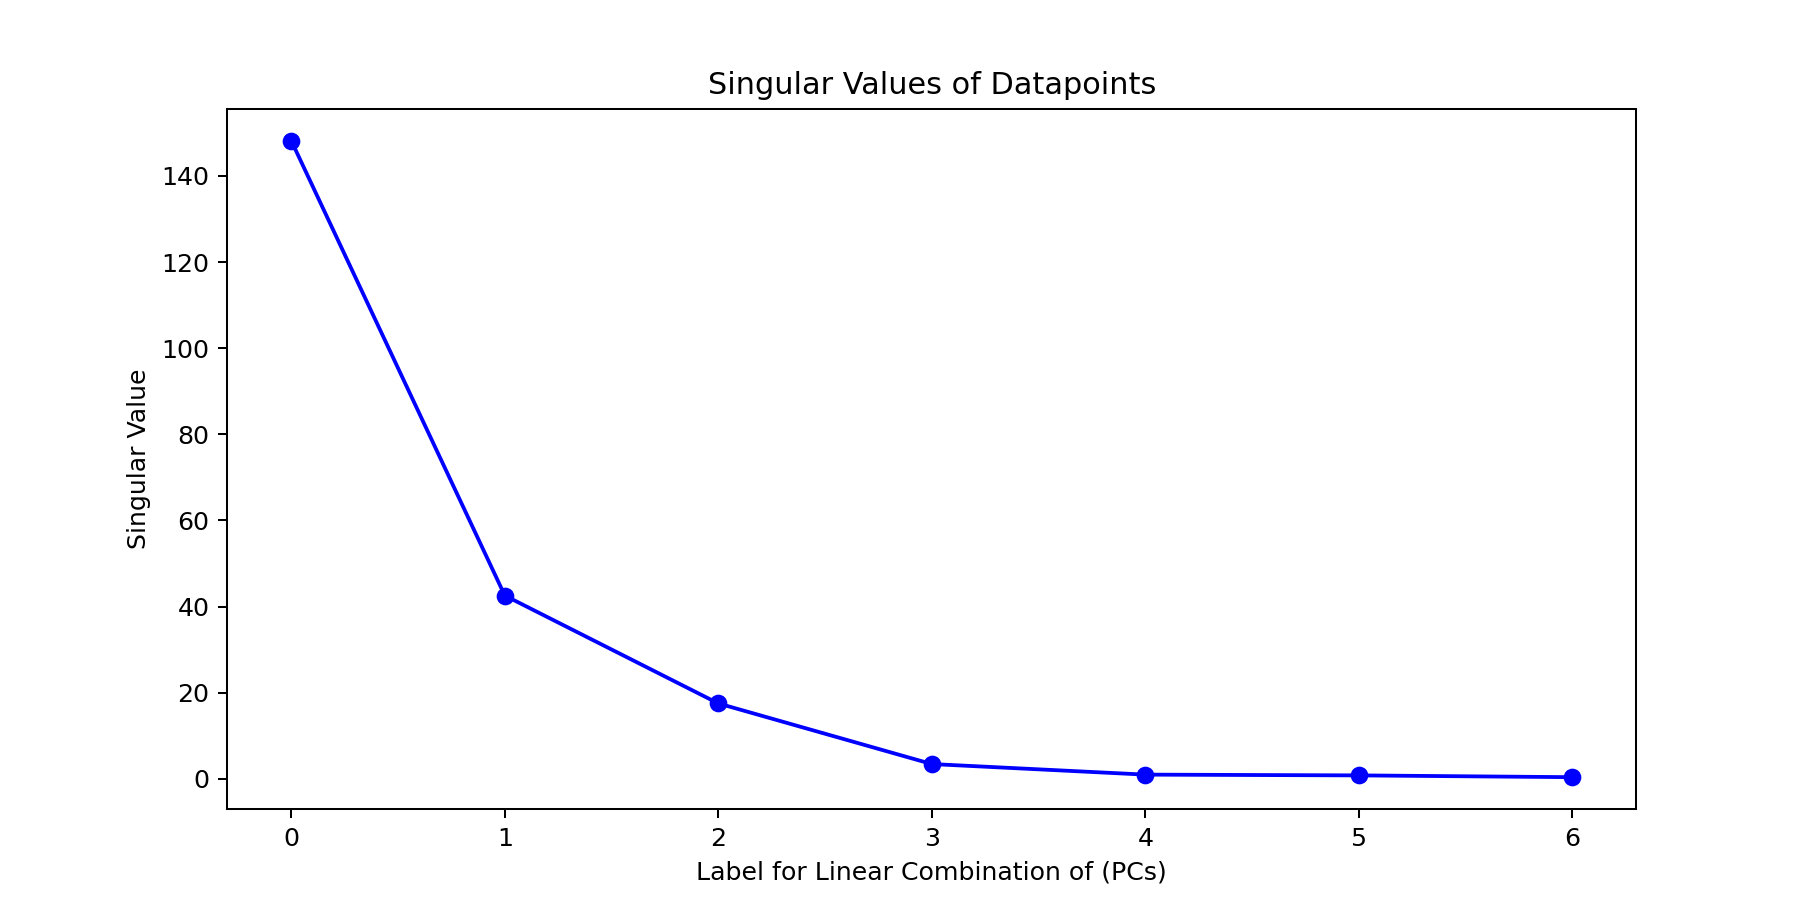

In [18]:
# plot the singlar values for the  D  matrix.
# 1. Calculate the D matrix using s: D is s*s
D       = cp.asnumpy(s*s)
labels  = range(len(X_centered[0]))

# 2. Set the fig size to (15,5)
fig     = plt.figure(figsize=(10,5))
ax      = fig.add_subplot(111)

# 3. Add the line chart using plt.plot( ?? ,'bo-')
ax.plot(labels,D,'bo-')

# 3. Add proper tital, ticks, axis labels
ax.set_title('Singular Values of Datapoints')
ax.set_xlabel('Label for Linear Combination of (PCs)')
ax.set_ylabel('Singular Value')
ax.set_xticks(labels);
# ax.set_yscale('log')

In [21]:
# Obtaining our compressed data representation:
# 1. Determine at least k singular values that are needed to represent the data set from the fig above
k = np.array(list(labels))

# 2. Obtain the first k of v^T and store it
v = vT[k].T

# 3. Calculate the compressed data using np.matmul(), X and stored first k of v^T
X_compressed = cp.matmul(X_centered,v).get()

# 4. Print the compressed value of X
# print(v)

# K-Means++ Clustering

In [22]:
# PARAMETERS
N_CLUSTERS  = 9
pyper       = []

<IPython.core.display.Javascript object>


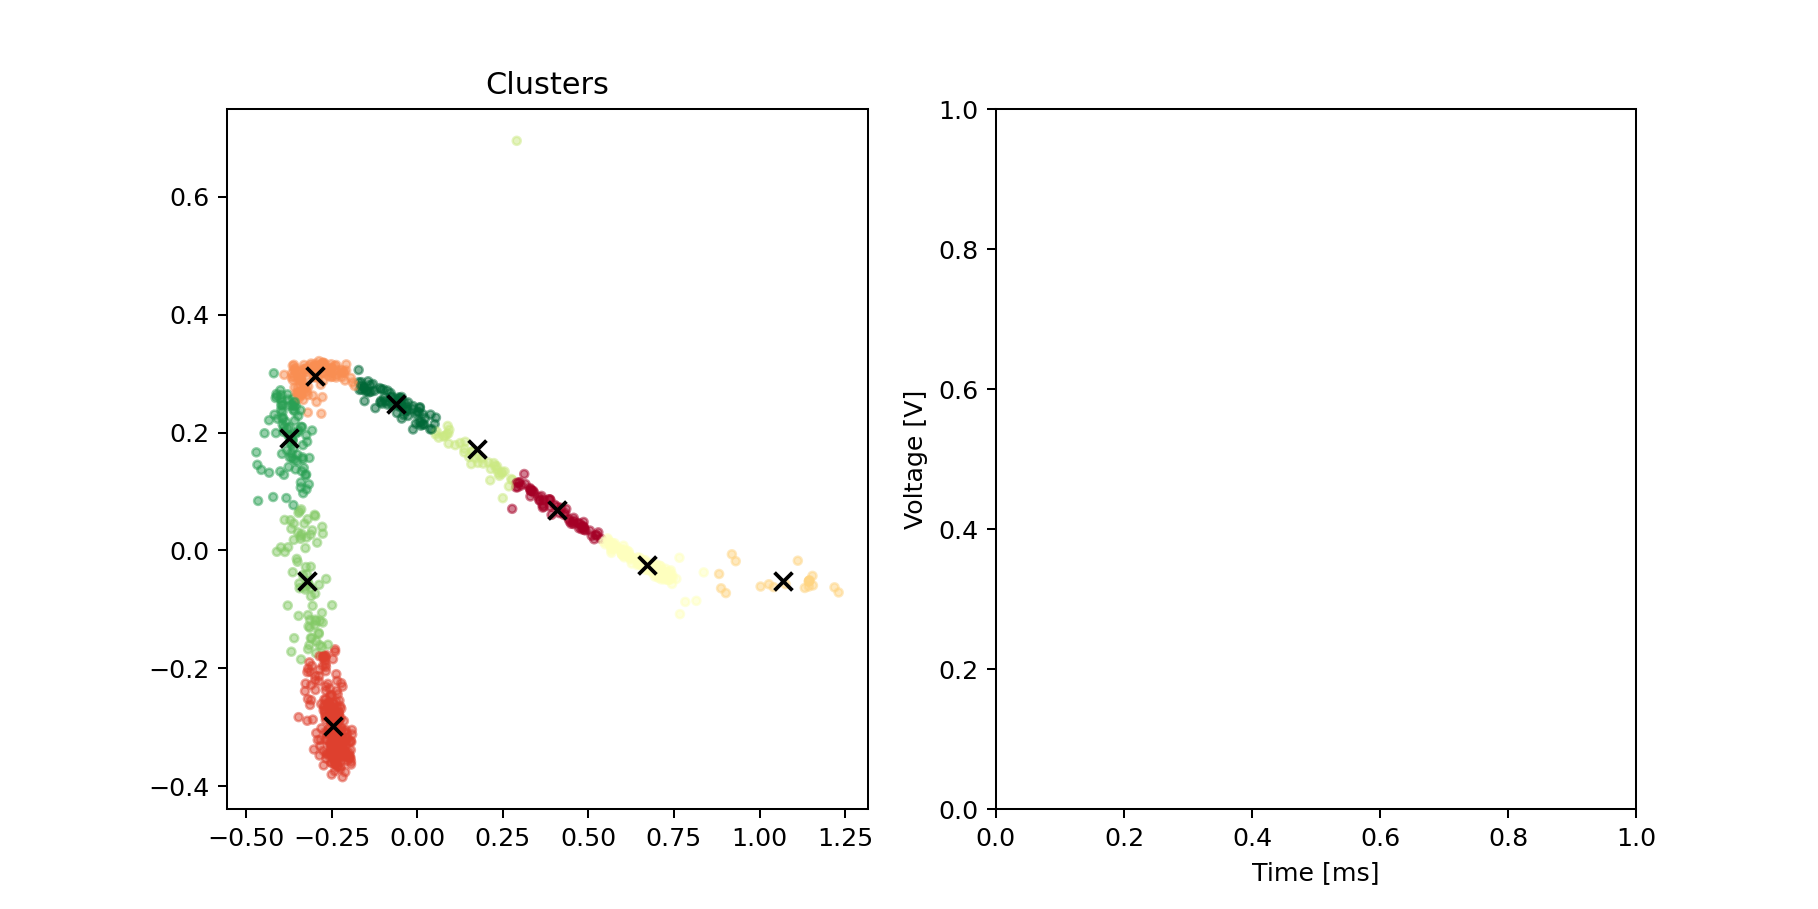

<function __main__.<lambda>(sel)>

In [23]:
# Get the centers
DATA    = X_compressed[:,[0,1]] #X_centered[:,[0,-1]] #

# params = {
#     "n_neighbors": 100,
#     "n_components": 2,
#     "eigen_solver": "dense",
#     "random_state": 0,
# }

# lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
# DATA = lle_hessian.fit_transform(DATA)

kmeans  = KMeans(n_clusters=N_CLUSTERS, n_init="auto").fit(DATA)
closestpoints=[]

fig     = plt.figure(figsize = (10,5))
ax1     = fig.add_subplot(121)
ax2     = fig.add_subplot(122)
cmap    = matplotlib.cm.get_cmap('RdYlGn')
COLORS  = np.array([kmeans.predict([x[:2]])[0] for x in DATA])
norm    = matplotlib.colors.Normalize(vmin=COLORS.min(),vmax=COLORS.max())
points  = ax1.scatter(*(DATA.T),s=10,alpha=0.5,c=cmap(norm(COLORS)))
centers = ax1.scatter(*kmeans.cluster_centers_.T,color='k',marker='x',s=50)
ax1.set_title('Clusters')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Voltage [V]')
IDX_SELECTED  = []

cursor_p = mplcursors.cursor(points)

def callback(sel):
    I = sel.index
    cursor_p.visible = True
    cursor_c.visible = False
    sel.annotation.set_text(sel.index)
    fig.suptitle(f'Idx {I}')
    ax2.clear()
    pyper.append(I)

    plot_signal(traces_filtered[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
    plot_signal(traces_filtered[I][1],fig=fig,ax=ax2,order=2,mysize=1/50,color='k',lw=1)
    ax2.plot(REFERENCE_VOLTAGE*traces_filtered[I][1].min()/REFERENCE_VOLTAGE.min(), color='deepskyblue',lw=1,ls=(0,(5,10)))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="]-", fc="k")
    CC = ['k']*9
    CC[COLORS[I]] = 'deeppink'
    centers.set_color(CC)
    
cursor_p.connect("add", lambda sel: callback(sel));

cursor_c = mplcursors.cursor(centers)

def callback_center(sel):
    I = sel.index
    idx_c = np.where(COLORS==I)[0]
    sel.annotation.set_text(len(idx_c))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="wedge", fc="k")
    fig.suptitle(f'Center {I}')
    ax2.clear()
    cursor_p.visible = False
    cursor_c.visible = True
    #pyperclip.copy(", ".join([str(i) for i in idx_c]))
    #PYPER = eval("[" + ", ".join([str(i) for i in idx_c]) + "]")
    pyper.append(idx_c)
    print((", ".join([str(i) for i in idx_c])))
    CC = ['k']*9
    CC[I] = 'cornflowerblue'
    centers.set_color(CC)

    ax2.set_title(f'Number of Points {len(idx_c)}')
    for i in idx_c:
        #plot_signal(traces_filtered[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
        plot_signal(traces_filtered[i][1],fig=fig,ax=ax2,order=2,mysize=1/50,lw=1,label=f'{i}')
    
cursor_c.connect('add', lambda sel:callback_center(sel))


In [24]:
print(pyper)
print(len(pyper))

[]
0


In [25]:
print(np.min(traces['C2'][800][1]))

-0.01178114302456379


In [26]:
c2max=0
c1max=0
for i in range(0,len(traces['C2'])):
    if -1*np.min(traces['C1'][i][1])>c1max:
        c1max=-1*np.min(traces['C1'][i][1])
    if -1*np.min(traces['C2'][i][1])>c2max:
        c2max=-1*np.min(traces['C2'][i][1])
        
print(c1max)
print(c2max)


0.3813862381502986
0.30070242285728455


In [68]:
selected=[206, 329, 455,
          499, 623, 655, 821, 901,
          987, 1261, 1399, 1564, 1777, 
          1858,2096, 2111, 2277, 2307]




<IPython.core.display.Javascript object>


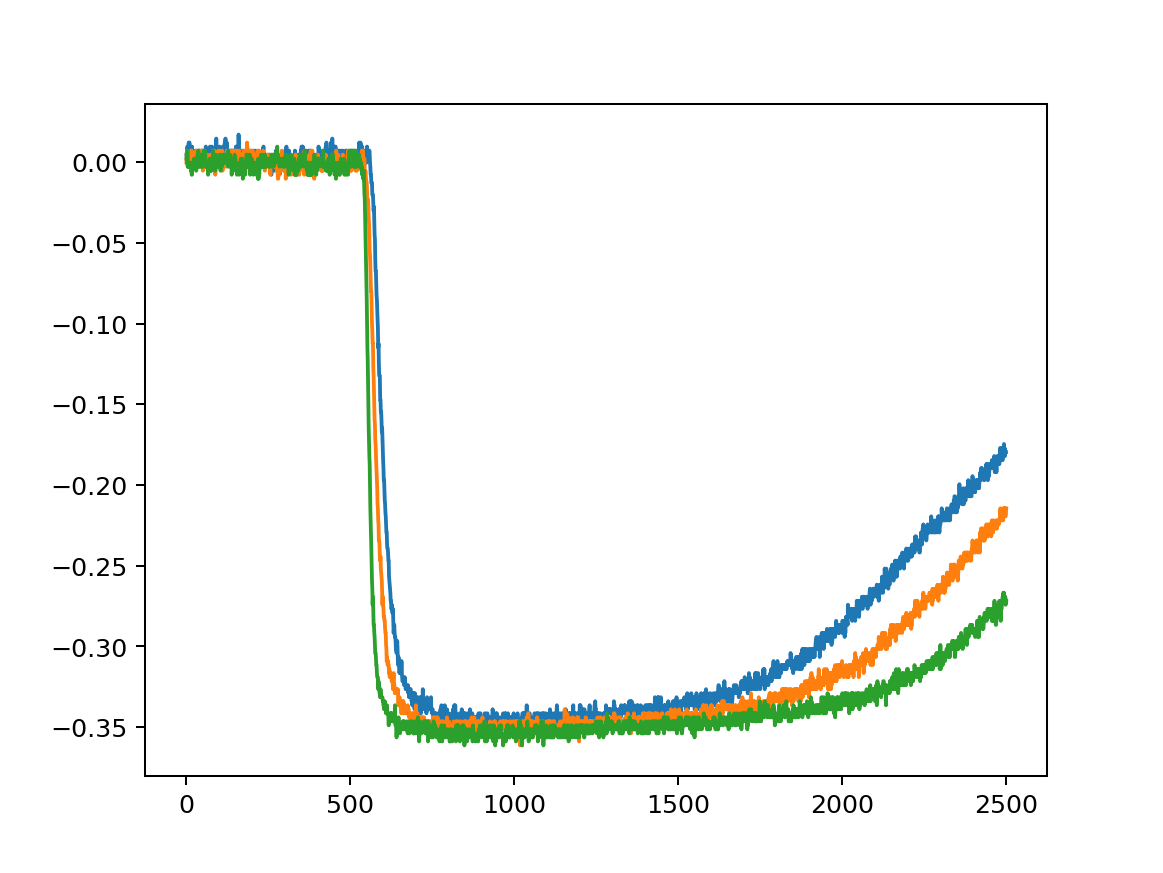

In [69]:
plt.figure()
for i in selected[-20:-15]:
    plt.plot(traces['C1'][i][1])

In [91]:
delay=[]
ampratio=[]
for i in range(0,len(selected)):
    t1=traces['C1'][i][0][np.argmin(np.abs(traces['C1'][i][1]+0.052))]
    t2=traces['C2'][i][0][np.argmin(np.abs(traces['C2'][i][1]+0.052))]
    delay.append((t1-t2)*1000000)
    ampratio.append((-1*np.min(traces['C1'][i][1])/c1max) / (-1*np.min(traces['C2'][i][1])/c2max))

In [92]:
nontamp=[0.05755183296053407, 0.056202526445830646, 0.36084173306135814, 16.010431961458764, 20.672108007244372, 11.792725062890833, 0.3101907011694084, 26.409894978929664]
nontdelay=[-13.509384771324676, -11.361718924343297, -2.609198762828471, 13.084802197583443, -21.015661181606074, 2.9874217395516394, -2.9082905130687666, -33.83801313636701]
nonttrigdelay=1000000*np.array([1.868000188647284e-05, -5.319997967667856e-06, -4.2799979739884255e-06, 1.3000001920992876e-05, -2.1119997871643814e-05, 3.6000001781211044e-05, 2.384000185511309e-05, -3.3839997794338384e-05])

<IPython.core.display.Javascript object>


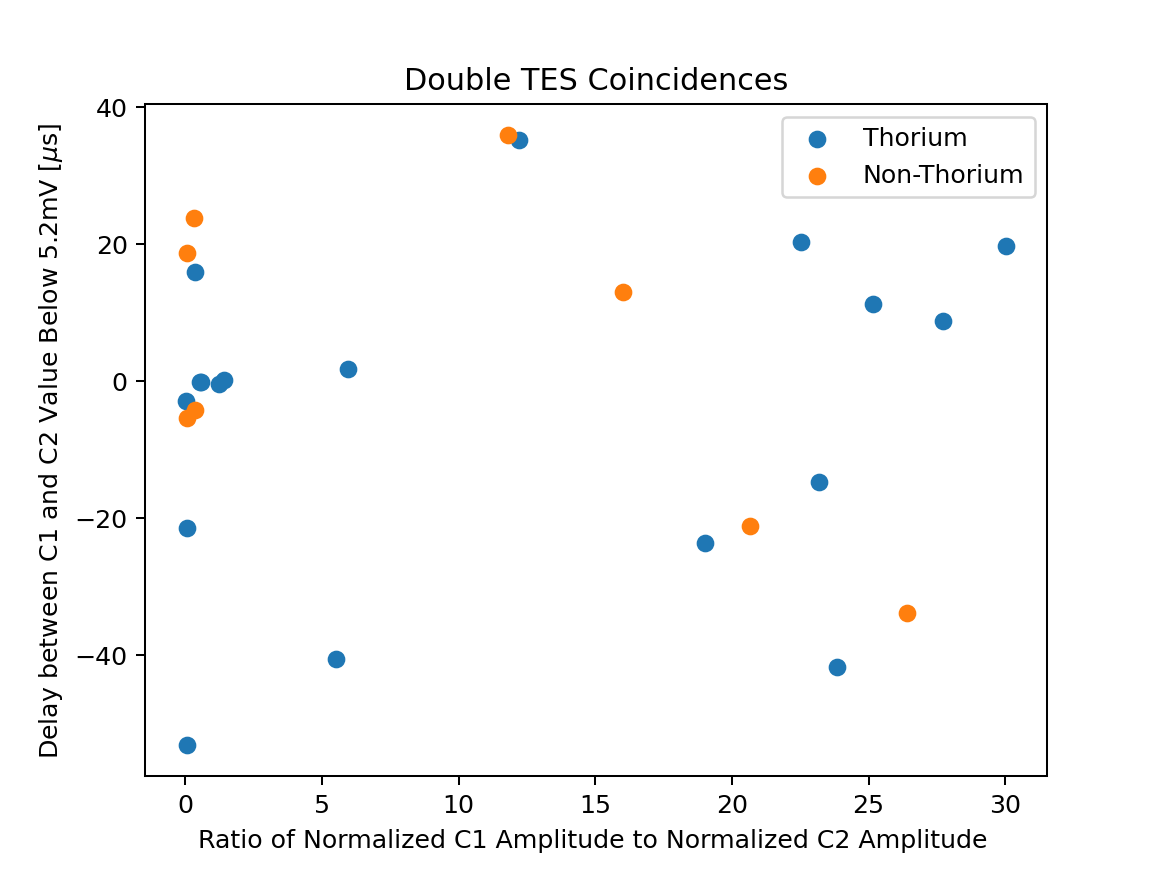

Text(0.5, 0, 'Ratio of Normalized C1 Amplitude to Normalized C2 Amplitude ')

In [93]:
plt.figure()
plt.scatter(ampratio,delay,label='Thorium')
plt.scatter(nontamp,nonttrigdelay,label='Non-Thorium')
plt.title("Double TES Coincidences")
plt.legend()
plt.ylabel(r'Delay between C1 and C2 Value Below 5.2mV [$\mu$s]')
plt.xlabel('Ratio of Normalized C1 Amplitude to Normalized C2 Amplitude ')

In [ ]:
plt.figure(22)
for i in selected[:1]:
    plt.plot(traces['C1'][i][0],traces['C1'][i][1])
    plt.plot(traces['C2'][i][0],traces['C2'][i][1])
    plt.axvline(traces['C1'][i][0][np.argmin(np.abs(traces['C1'][i][1]+0.052))])
    plt.axvline(traces['C2'][i][0][np.argmin(np.abs(traces['C2'][i][1]+0.052))])
plt.title('Chan1 TES E')

In [ ]:
selected=np.unique([548])
# print(len(selected))
# selected=[4, 211, 600, 760, 
#           869,
#           972, 1063, 1484,
#           1519, 1554]

#selected=np.unique([4, 211, 600, 760,
#                    869, 
#                    972, 1063, 1484, 1519, 1554])

# selected=[300, 373, 446, 448, 449,
#           450, 457, 510, 521, 524, 533, 568,
#           218, 447, 511, 562, 567, 569, 570, 451]
print(len(selected))

In [ ]:
i=548
fig     = plt.figure(figsize = (10,5))
ax1     = fig.add_subplot(111)
ax1.plot(traces['C1'][i][0],traces['C1'][i][1],color='b',label='Scint 1 Chan 1')
ax1.plot(traces['C2'][i][0],traces['C2'][i][1],color='r',label ='TES B Chan 2')
ax1.plot(traces['C3'][i][0],traces['C3'][i][1],color='orange',label='Scint 2 Chan 3')
ax1.plot(traces['C4'][i][0],traces['C4'][i][1],color='green',label='Scint 3 Chan 4')
ax1.set_xlabel('time [s]')
ax1.legend()
ax1.set_title('Quadruple Coincidence of Muon Sabers and TES')


In [ ]:
print(len(selected))

In [ ]:
plt.figure()
for i in selected[:]:
    plt.plot(othertes_filtered[i][1])

In [ ]:
traceamp=[]
tracearea=[]
for i in range(0,len(traces_filtered)):
    traceamp.append(-1*traces_filtered[i][1].min())
    tracearea.append(-1*np.sum(traces_filtered[i][1]))

In [ ]:
traceareathor=[283.19164545228705, 0.3999800132587552, 533.1889272900298, 177.9321436677128, 4.300417291000485, -3.139305664692074, 8.479813045822084, 58.61263649817556, 108.90486479457468, 533.4597413046286, 6.863348299171776, 270.6459860857576, 67.06607463397086, 253.44271643226966, 376.99143337039277, 8.57264133170247, 129.79935286799446, 261.86128475843, 190.45538672804832, 303.34888612199575, 438.8380221594125, 214.17183868121356, 211.18797925673425, 311.12236296990886, 481.34997386625037, 59.91776365879923, 336.06423966167495, 512.95380253857, 117.25369350146502, 111.8164938990958, 555.0840046796948, 497.5861792922951, 87.1560663850978, 399.0914205769077, 127.87155053531751, 138.2826794120483, 294.29020771896467, 254.54111543577164, 301.8743913145736, 509.12377724051476, 560.030536246486, 60.05475219665095, 464.5943579762243, 552.5061294673942, 536.620440477971, 429.9287857976742, 345.73064903263, 56.96130194189027, 549.8983658468351, 537.8956792303361, 380.71254019858316, 312.2083084699698, 362.5005367663689, 359.9924011733383, 244.59325688704848, 276.73076786706224, 526.5530282962136, 543.0215412466787, 549.7165446965955, 552.5808504880406, 440.53917072946206, 268.64097203174606, 57.118216085247695, 122.86026075063273, 426.13295794883743, 289.1817806074396, 66.71737653762102, 399.7738725654781, 193.06065964791924, 65.56169141829014, 547.3983747162856, 545.4923163293861, 63.108351240400225, 419.7841618945822, 144.21303775068372, 434.0334605318494, 525.1109125977382, 84.306704797782, 545.6990444865078, 535.1583991739899, 202.10688454750925, 444.3848125920631, 536.382005572319, 195.16779243014753, 3.1528766341507435, 223.55430817371234, 554.5858645420521, 543.4773394726217, 96.37913103355095, 240.8148639430292, 98.4215055978857, 316.93067697482184, 93.08642472373322, 489.30459950398654, 56.989372009877115, 501.3371745287441, 543.6025468674488, 321.11007272964343, 445.26652063569054, 541.9007259369828, 523.7068297700025, 548.0552473375574, 153.5955072431825, 246.73027807753533, 137.0472918706946, 122.53397896047682, 410.8002045121975, 491.6483488515951, 419.9510388406925, 53.68852123757824, 48.48295679921284, 315.6155870114453, 442.2751891091466, 223.3009290639311, 532.1048001302406, 429.54023649031296, 514.1368853654712, 420.07806457579136, 123.0246469960548, 538.1721470067278, 377.21559643233195, 542.2568961353973, 526.9963730187155, 166.37031107302755, 54.68978291423991, 65.35247256048024, 322.0714831952937, 67.85811745282263, 518.0572482487187, 259.76976854074746, 77.3153079659678, 355.95995675912127, 61.82314968528226, 261.60723328823224, 520.958914550487, 507.60626816097647, 337.3643854209222, 134.09083015378565, 151.82960045523942, 542.0875284885988, 78.55318620800972, 530.9373338678852, 415.5474800239317, 555.4227399732918, 264.2374132149853, 536.7150871041231, 398.0851774988696, 55.0484438133426, -0.39206280559301376, 523.8282017433085, 452.950332258828, 540.4013241226785, 520.2789532626048, 74.20691350707784, 72.49580213427544, 69.21804002858698, 356.08947319490835, 473.5060850386508, 531.7710462380201, 63.46701213950291, 515.115730735939, 533.7660974892788, 529.1458477126434, 482.6469565643929, 383.8415326233953, 54.41647819895297, 156.22319646924734, 291.89166295621544, 242.27192384563386, 442.09336795890704, 539.7437791409902, 518.1269878679886, 103.49008149839938, 531.4123853389174, 538.8819967028685, 63.33500500302762, 518.5187002364546, 536.2151286262088, 542.6504268441349, 373.1059402967803, 283.05963831581175, 108.19003369705752, 490.9484619582072, 555.4351934767328, 209.39965616259724, 314.2108318232931, 446.7385247424245, 400.98435309994966, 536.8271686350927, 529.0063684741035, 147.15704596415162, 539.121103968937, 531.0736500453204, 545.9954378684051, 443.40347652090713, 55.58643516199663, 515.0933144297451, 246.8747387174517, 534.8072103769518, 376.79964941740036, 250.95699714543298, 454.6415180261247, 78.48095588805154, 122.10557844210416, 60.48813411640003, 550.3267663652077, 415.3955472819507, 221.90048291673884, 404.4688433627598, 472.62686769571155, 376.19191844947636, 363.8305709338747, 226.27166262455285, 484.21609799796715, 389.1161643206142, 503.84032872039825, 548.436324542854, 300.63402237184346, 498.02454261342064, 58.36356642935425, 548.992423156742, 253.93587516853586, 389.4275019066408, 397.5297512453981, 528.0325045050122, 539.9928492098115, 541.8982352362946, 537.3875762899406, 97.86857004510239, 59.887875250540674, 167.68041963502765, 542.6578989461996, 425.029577543959, 75.98278309777379, 446.04610995110124, 537.4324089023285, 433.4581086728722, 118.29978779051453, 434.00108142290264, 518.5130464746617, 61.745937963947654, 82.8820240041241, 144.91790604544804, 541.1012110160664, 183.08291269093752, 520.8468330195174, 550.0901497998275, 54.610080492217094, 83.5644759926945, 551.6493284306489, 82.78239597659558, 136.0410487926565, 539.0937062613666, 61.86051019560546, 486.4079146035947, 68.43097861111164, 528.0947720222175, 388.58066367264837, 536.4884333414957, 456.36010150099173, 1.3620628393255174, 521.1357542993501, 74.70505364472046, 177.86987615050748, 371.49445695150644, 100.31692882161587, 219.1358051528223, 122.06074582971632, 227.11102875648066, 388.9243803676218, 87.1735012899153, 373.4247499848716, 165.05771181033924, 528.4708678261377, 151.3140254127793, 525.1358196046203, 551.743975056801, 532.8420475339517, 324.83616095921025, 554.6805111682042, -3.0845102495513856, 65.80578008573502, 556.4862691671588, 540.4909893474542, 51.43510947516188, 558.6382345617749, 250.55350363394246, 529.3550665704533, 287.4233459215611, 539.6765302224085, 315.30243108514696, 240.3416308122687, 459.07994665252045, 540.6105429804884, 545.4126139073633, 324.2334113926627, 505.90761029161513, 537.3875762899406, 211.85548704117537, 382.62856138823554, 480.2683374071494, 233.22320824535564, 306.0014823549427, 531.4148760396056, 523.775897028856, 453.219327933155, 77.1434496184811, 506.88147426070645, 523.5442618648522, 539.4822555687279, 518.8673983328044, 546.5359199177474, 538.71262905607, 60.834341512061656, 411.94841752946377, 477.27949658129364, 78.98158672638237, 65.02868147101253, 133.48558988654986, 429.72454834124073, 537.0513316970319, 60.08464060490951, 199.018415694125, 548.8896320681088, 520.8617772236466, 101.54235356021672, 227.7237411257811, 551.6792168389075, 408.2123664971441, 77.34337803395465, 73.42483349097893, 201.26751841558143, 543.9929145150818, 88.3516027154401, 235.91814639000222, 290.7260150341317, 93.3305133911781, 205.94256360735744, 541.6093139564618, 461.68272887170315, 178.83377731684595, 449.54305371735245, 411.31827025534585, 399.00424605282024, 539.5744114941917, 203.93256815196946, 543.0962622673251, 529.935399830807, 474.54537958605215, 524.0598369073123, 533.1010804055259, 386.8994407081045, 480.6301613673568, 135.74216471007094, 468.29055779753253, 530.8619404868223, 185.76788803283125, 255.13390219956636, 385.1883293353021, 543.2108344989829, 300.7411225014366, 536.6951614986174, 236.11740244505927, -0.8229540246538818, 444.50436622509733, 57.83553788345307, 55.10323922848329, 115.6347380541265, 104.98450191132724, 427.88142983196303, 367.5747664286755, 558.2945178668015, 231.9604229964316, 473.321773187723, 555.3031863402575, 550.2801154125482, 78.90686570573598, 379.6016876916401, 422.32218589587137, 78.34713041130453, 550.7003714684397, 554.1456828806549, 517.7434199620038, 333.4340597349219, 403.7863913741894, 547.3977023558691, 541.1111738188192, 542.3316171560436, 269.049446944613, 554.5385412289761, 111.89619632111862, 136.55911453580484, 329.7453320156783, 453.49828641023487, 127.15173803642392, 534.0674722725525, 291.93151416722685, 525.2055592238903, 216.71982548525557, 535.0488083437085, 66.69246953073889, 542.0352237741463, 543.5470790918916, 546.5533548225649, 414.4042484080419, 391.4698764709756, 53.32736963778734, 513.4369984720834, 103.08160658553243, 552.6157202976756, 80.72258650744334, 218.66506272275, 552.2047546841204, 288.30007256381214, 62.24656880227849, 148.64715733611956, 358.4132969370112, 101.23101597419009, 463.88948968145996, 60.51620418438688, 416.4192252648063, 526.966484610457, 565.8239060472697, 334.3630910916254, 233.3875944907777, 539.8035559575073, 548.0851357458159, 532.0201163068414, 559.3729912647977, 566.2049832525663, 493.038159835618, 449.9123497796245, 543.3602765402757, 60.899099729955196, 517.3374357498251, 175.84493649099022, 552.0876917517744, 157.78237510006875, 63.9203196647577, 61.33497235039249, 540.8347060424276, 124.21022052364424, 217.32755645317957, 532.1820118515752, 554.4065340925008, 105.48264204896986, 89.17602464323863, 67.9477826775983, 559.8163359872997, 526.5337750511244, 547.7065492412075, 489.1252690544352, 537.6266835560091, 528.2591582676396, 482.29825846804306, 524.839426222723, 415.2261796351522, 439.6325556789525, 208.39839448593557, 551.2109651095234, 534.2300401777029, 71.02130732685328, 562.8425373234786, 453.2716326476075, 212.2216200423427, 556.6730717187747, 369.1108563928865, 52.64740834990516, 83.39261764520779, 235.56264855200425, 199.01094359206036, 78.2841905336827, 199.53648143727332, 170.93576543452218, 527.9004973685369, 544.3665196183138, 399.27075102645904, 558.5834391466342, -0.7930656163953245, 145.01753407297656, 308.17586405575275, 349.8826470798813, 195.4118810975924, 526.3164117308334, 85.84097642172128, 369.6239407346584, 51.34228118928149, 553.6966843963601, 408.90229058777913, 103.59469092730433, 352.15416610753164, 234.0526115745306, 427.65477606933564, 402.7203714796342, 110.47218788787723, 496.56566437054425, 539.2605832074769, 62.60024830000475, 558.4496136698872, 245.36288339970633, 319.72773384768516, 66.72733934037387, 127.71214569127187, 198.5252569578588, 227.70132481958717, 316.3677786192857, 310.9611397855915, 71.04123293235898, 400.4986664657481, 130.6835516123101, 59.71103550167754, 552.3292897185311, 300.31272198306397, 81.99035315774381, 62.107089563738555, 560.9520955011249, 248.82246665563434, 546.3814964750782, 56.18420332716778, 509.94254540652037, 465.2618657606654, 406.142594225239, 549.1785533479415, 59.768321617506444, 163.40637725405395, 522.4981675758027, 484.2210793993436, 63.41719812573865, 542.628010537941, 549.6941283904016, 287.3959482139908, 507.5564541472122, 416.97963291965425, 554.5285784262232, 119.77179189724848, 369.40724977478385, 325.36917090648785, 528.0872999201529, 314.4300134838559, 61.290139738004655, 423.9834832549095, 144.93783165095374, 63.990059284027666, 542.102472692728, 485.83256274461746, 561.0268165217713, 211.2377932704985, 432.27004444459453, 451.2292580832727, 318.0614550872706, 522.899170386605, 539.0837434586138, 525.4994619050995, 529.9603068376891, 52.74205497605726, 334.9359522499144, 545.1261833282188, 115.15403282130137, 59.01363930897787, 554.4314410993829, 526.4832886769436, 504.96114403009415, 231.71882502967492, 557.096490835771, 555.8038171785884, 556.267087506596, 57.34554220829159, 1.7200513780117035, 533.3078085626476, 412.06049906043336, 159.68527042586356, 518.9339748909697, 69.31019595405087, 249.98811457771808, 221.51940571144223, 541.5495371399447, 60.762111192103475, 455.2524120551534, 83.24068490322679, 519.3872824162245, 515.8729037451558, 247.73652115557343, 499.0980346100405, 542.6205384358764, 493.18012977484614, 313.6230264608748, 555.168688503094, 304.9379531610757, 415.58982193563133, 424.5164932021871, 118.87015824811533, 477.41150371776894, 547.4375535668805, 548.167328868527, 442.23035649675876, 529.9378905314952, 54.52539666881785, 553.4525957289152, 552.8056859103963, 552.6605529100634, 323.33675914490595, 319.5608569015749, 551.7962797712535, 180.09158116439357, 498.06688452512026, 556.2446712004021, 85.72640419006348, 135.57279706327245, 451.4957630569115, 124.66601874958724, 501.0930858612992, 222.69750713696703, 550.5135689168237, 2.1708682025782764, 60.5585460960865, 503.4542701137252, 535.5867996923625, 542.4138102787547, 73.83081770315766, 5.862086622510105, 144.4172752071172, 58.18921738117933, 330.36867954814807, 555.1138930879533, 552.6655343114398, 548.448778046295, 52.71714796917513, 111.35571427177638, 393.9008003426716, 550.6630109581165, 59.01114860828966, 441.71727215498686, 516.3436461752281, 326.06905779987574, 399.071494971402, 558.5560414390638, 461.16715382924303, 1.6254047518596053, 554.5584668344818, 354.7924904967658, 552.924567183014, 538.9666805262677, 54.298742906190455, 564.6109348121099, 550.8024901966564, 310.9430325203575, 558.9171930388547, 220.14952033292502, 169.87970834271982, 271.71947808237746, 299.32209546957165, 555.2757886326872, 328.6245167059824, 191.37512764241546, 532.062458218541, 121.25375880673528, 406.2920362665318, 115.46786110801622, 368.1992599410005, 406.37672008993104, 335.0281081753783, 372.4757930226624, 57.317472140304744, 184.6943960362114, 404.4314828524366, 498.2661405801773, 81.80671366723254, 544.9368900759146, 76.97408197168261, 88.15483736107126, 86.65792624745518, 555.4277213746682, 273.2437869035639, 211.70355429919437, 61.30010254075751, 75.35579888476059, 385.2979201655835, 301.10725550260395, 145.43597178859636, 82.7101656566374, 556.8822905765846, 84.25440008332953, 555.308167741634, 557.6319914837368, 494.16893794806674, 492.44039167044684, 559.2907981420867, 59.44702122872695, 537.9380211420357, 161.94682665076107, 50.97682054853067, 256.0380265493877, 465.5707126460038, 546.5384106184356, 232.08495803084224, 65.59407052723691, 532.5805239616893, 509.15797468973324, 537.4896950181574, 153.31654876610264, 473.8921436453238, 3.025178538635373, 301.2268091356382, 104.71550623700023, 58.3735292321071, 52.86908071115613, 242.65300105093047, 324.2209578892216, 562.2497505596839, 470.6741583561525, 543.609346609097, 487.30954825272784, 353.8435335345566, 217.37986116763204, 232.61298657674342, 62.16935708094388, 541.6840349771082, -0.17039044434204698, 3.2593044033274055, 517.0883656810038, 539.8914028420113, 244.7078291187063, 69.32514015818015, 212.85674871783704, 59.06096262205392, 112.11288728099316, 228.78228891827166, 431.47800162574276, 255.6718935482204, 558.5435879356228, 550.3691082769074, 147.40362533228472, 532.1297071371228, 280.1579720140435, 408.8151160636917, 537.8857164275832, 53.53160709422082, 99.87109339842573, 548.3640942228958, 162.43251328496262, 223.82081314735115, 84.71019830927253, 108.13772898260504, 60.169324428308755, 554.7751577943563, 187.80279049510136, -0.2718368121422827, 155.78483314812183, 55.13810903811827, 533.4504508622922, 493.3096462106332, 524.4259699084796, 89.72646949533373, 102.14261242607608, 57.43702577333897, 501.67590982234105, 75.38252423191443, 265.3482657219283, 506.0552339926362, 345.6534373112954, 160.6441901908256, 503.3895118958317, 206.81679954892024, 165.67042417963967, 152.19075205503032, 146.97522481391206, 541.1759320367128, 310.0986849870533, 530.2748074848205, 358.6847833120264, 476.15619057090953, 535.9653861969709, 69.12339340243489, 289.33122264873236, 557.0167884137481, 138.2054676907137, 501.07066955510527, 358.2663455964066, 552.6630436107516, 451.6252794926986, 73.2113055922091, 223.9453481817618, 444.3424706803635, 78.74497016100213, 57.28758373204619, 67.69373120740056, 320.8336049532518, 542.0053353658877, 79.6142247011885, 100.3791963388212, 439.4880950390361, 69.4123146822676, 560.0977851650678, 373.3649731683545, 68.10469682095572, 541.6367116640322, 435.82676502736285, 345.157787874341, 522.4682791675441, 537.9728909516707, 61.5840424192138, 524.2516208603047, 556.0603593494743, 353.77312155487016, 433.99859072221443, -0.22020445810630918, 354.4231944344938, 518.7770607476123, 479.32934324769303, 543.7762235552073, 2.3576707541942596, 538.3365332521498, 520.2789532626048, 427.5177875314839, 414.1203085295856, 68.49573682900518, 552.8050135499798, 388.88203845592216, 3.677742118947208, 3.5781140914186835, 268.2125715133734, 59.576537664514035, 553.684230892919, 525.4546292927116, 303.1471393662505, 163.95433140546083, 126.9201028724201, 165.09574468107894, 556.8057512156665, 559.5074891019613, 79.61671540187672, 75.73371302895248, 72.70003959070891, 83.37767344107851, 411.9010942163877, 55.979965870734304, 290.73846853757277, 530.2417560154572, 564.366846144665, 54.94134368374944, 560.2472272063605, 532.77048957441, 52.92387612629682, 248.51611047098413, 82.69273075181991, 549.1461742389947, 498.8315296364017, 527.4378994009458, 434.4892587577924, 538.3763844631612, 309.7823659996502, 59.45449333079159, 298.6041013109498, 326.92336813593283, 473.4943038956262, 410.6258554640226, 504.39326427318156, 2.5003130538389087]

In [ ]:
traceampthor=[0.23096280358731747, 0.0889928643591702, 0.288248919416219, 0.1612231843173504, 0.05910445610061288, 0.05910445610061288, 0.11888127261772752, 0.05661375541239977, 0.10144636780023575, 0.2857582187280059, 0.1138998712413013, 0.22100000083446503, 0.06159515678882599, 0.2135278987698257, 0.2633419125340879, 0.17616738844662905, 0.12137197330594063, 0.21850930014625192, 0.17118598707020283, 0.2409256063401699, 0.27579541597515345, 0.1886208918876946, 0.18363949051126838, 0.24341630702838302, 0.27828611666336656, 0.06159515678882599, 0.25337910978123546, 0.288248919416219, 0.11639057192951441, 0.10393706848844886, 0.29821172216907144, 0.28077681735157967, 0.08401146298274398, 0.2683233139105141, 0.11639057192951441, 0.12635337468236685, 0.2384349056519568, 0.2160185994580388, 0.24341630702838302, 0.2832675180397928, 0.29821172216907144, 0.06159515678882599, 0.28077681735157967, 0.2932303207926452, 0.2907396201044321, 0.2708140145987272, 0.2583605111576617, 0.05412305472418666, 0.2957210214808583, 0.2907396201044321, 0.2633419125340879, 0.24839770840480924, 0.265832613222301, 0.2583605111576617, 0.20605579670518637, 0.22847210289910436, 0.288248919416219, 0.2907396201044321, 0.2932303207926452, 0.2932303207926452, 0.27579541597515345, 0.21850930014625192, 0.05661375541239977, 0.11639057192951441, 0.27330471528694034, 0.23096280358731747, 0.06657655816525221, 0.2708140145987272, 0.17118598707020283, 0.06906725885346532, 0.2932303207926452, 0.2932303207926452, 0.05910445610061288, 0.27330471528694034, 0.13382547674700618, 0.27579541597515345, 0.2857582187280059, 0.08152076229453087, 0.2932303207926452, 0.2907396201044321, 0.17865808913484216, 0.27579541597515345, 0.2907396201044321, 0.17367668775841594, 0.08152076229453087, 0.19858369464054704, 0.29821172216907144, 0.2932303207926452, 0.09148356504738331, 0.20854649739339948, 0.09397426573559642, 0.24839770840480924, 0.08650216367095709, 0.2832675180397928, 0.05412305472418666, 0.2857582187280059, 0.2907396201044321, 0.24839770840480924, 0.27828611666336656, 0.2932303207926452, 0.288248919416219, 0.29821172216907144, 0.1388068781234324, 0.20605579670518637, 0.12386267399415374, 0.10891846986487508, 0.2708140145987272, 0.28077681735157967, 0.27330471528694034, 0.05412305472418666, 0.05412305472418666, 0.24839770840480924, 0.27579541597515345, 0.19360229326412082, 0.288248919416219, 0.27330471528694034, 0.2857582187280059, 0.2708140145987272, 0.11140917055308819, 0.2907396201044321, 0.2633419125340879, 0.2907396201044321, 0.2857582187280059, 0.15375108225271106, 0.05661375541239977, 0.0640858574770391, 0.24839770840480924, 0.0640858574770391, 0.288248919416219, 0.2110371980816126, 0.07404866022989154, 0.2583605111576617, 0.06159515678882599, 0.21850930014625192, 0.288248919416219, 0.2832675180397928, 0.25337910978123546, 0.12137197330594063, 0.14378827949985862, 0.2907396201044321, 0.07404866022989154, 0.288248919416219, 0.2683233139105141, 0.2957210214808583, 0.22100000083446503, 0.288248919416219, 0.2708140145987272, 0.05412305472418666, 0.06906725885346532, 0.2857582187280059, 0.28077681735157967, 0.2907396201044321, 0.2832675180397928, 0.06906725885346532, 0.07155795954167843, 0.06906725885346532, 0.2583605111576617, 0.2832675180397928, 0.288248919416219, 0.06657655816525221, 0.2832675180397928, 0.288248919416219, 0.288248919416219, 0.28077681735157967, 0.265832613222301, 0.05412305472418666, 0.1388068781234324, 0.2384349056519568, 0.20107439532876015, 0.27579541597515345, 0.288248919416219, 0.2857582187280059, 0.09895566711202264, 0.288248919416219, 0.288248919416219, 0.05910445610061288, 0.288248919416219, 0.288248919416219, 0.2932303207926452, 0.2633419125340879, 0.23345350427553058, 0.09895566711202264, 0.27828611666336656, 0.29821172216907144, 0.1886208918876946, 0.24341630702838302, 0.27828611666336656, 0.265832613222301, 0.2907396201044321, 0.288248919416219, 0.1363161774352193, 0.2907396201044321, 0.288248919416219, 0.2932303207926452, 0.27828611666336656, 0.05412305472418666, 0.288248919416219, 0.20605579670518637, 0.288248919416219, 0.265832613222301, 0.2110371980816126, 0.27330471528694034, 0.07653936091810465, 0.11639057192951441, 0.0640858574770391, 0.2957210214808583, 0.27579541597515345, 0.19360229326412082, 0.2683233139105141, 0.28077681735157967, 0.265832613222301, 0.2633419125340879, 0.19858369464054704, 0.28077681735157967, 0.2633419125340879, 0.2857582187280059, 0.2932303207926452, 0.2384349056519568, 0.2832675180397928, 0.05661375541239977, 0.2932303207926452, 0.2135278987698257, 0.2683233139105141, 0.2683233139105141, 0.288248919416219, 0.2907396201044321, 0.2907396201044321, 0.2907396201044321, 0.09646496642380953, 0.05910445610061288, 0.15375108225271106, 0.2932303207926452, 0.2708140145987272, 0.07903006160631776, 0.27579541597515345, 0.2932303207926452, 0.27579541597515345, 0.12137197330594063, 0.27828611666336656, 0.2857582187280059, 0.06657655816525221, 0.08152076229453087, 0.1363161774352193, 0.2932303207926452, 0.1612231843173504, 0.2832675180397928, 0.29821172216907144, 0.05661375541239977, 0.08650216367095709, 0.2932303207926452, 0.08401146298274398, 0.12635337468236685, 0.2957210214808583, 0.06159515678882599, 0.2832675180397928, 0.06657655816525221, 0.288248919416219, 0.2633419125340879, 0.288248919416219, 0.27579541597515345, 0.24590700771659613, 0.2857582187280059, 0.07404866022989154, 0.15873248362913728, 0.2608512118458748, 0.09148356504738331, 0.1911115925759077, 0.11140917055308819, 0.19858369464054704, 0.265832613222301, 0.08152076229453087, 0.2583605111576617, 0.14627898018807173, 0.288248919416219, 0.1388068781234324, 0.2857582187280059, 0.2932303207926452, 0.288248919416219, 0.24839770840480924, 0.2957210214808583, 0.1412975788116455, 0.06906725885346532, 0.2957210214808583, 0.2907396201044321, 0.05661375541239977, 0.29821172216907144, 0.2135278987698257, 0.288248919416219, 0.23345350427553058, 0.288248919416219, 0.24839770840480924, 0.20605579670518637, 0.28077681735157967, 0.2907396201044321, 0.2932303207926452, 0.24590700771659613, 0.2857582187280059, 0.2907396201044321, 0.1886208918876946, 0.265832613222301, 0.2832675180397928, 0.19609299395233393, 0.2409256063401699, 0.288248919416219, 0.288248919416219, 0.27828611666336656, 0.07903006160631776, 0.2857582187280059, 0.288248919416219, 0.288248919416219, 0.288248919416219, 0.2932303207926452, 0.288248919416219, 0.06159515678882599, 0.27330471528694034, 0.2832675180397928, 0.07404866022989154, 0.06159515678882599, 0.12386267399415374, 0.27330471528694034, 0.2932303207926452, 0.05910445610061288, 0.17616738844662905, 0.2932303207926452, 0.288248919416219, 0.09397426573559642, 0.19360229326412082, 0.2932303207926452, 0.27330471528694034, 0.07903006160631776, 0.06906725885346532, 0.18114878982305527, 0.2932303207926452, 0.08650216367095709, 0.20107439532876015, 0.2359442049637437, 0.0889928643591702, 0.1861301911994815, 0.2932303207926452, 0.27579541597515345, 0.1612231843173504, 0.27828611666336656, 0.27579541597515345, 0.27330471528694034, 0.2907396201044321, 0.1861301911994815, 0.2907396201044321, 0.288248919416219, 0.28077681735157967, 0.2907396201044321, 0.288248919416219, 0.265832613222301, 0.28077681735157967, 0.12386267399415374, 0.27828611666336656, 0.2857582187280059, 0.1662045856937766, 0.2135278987698257, 0.2633419125340879, 0.2932303207926452, 0.2384349056519568, 0.2907396201044321, 0.19858369464054704, 0.05412305472418666, 0.27330471528694034, 0.06159515678882599, 0.05661375541239977, 0.10891846986487508, 0.09895566711202264, 0.27828611666336656, 0.2633419125340879, 0.29821172216907144, 0.20356509601697326, 0.28077681735157967, 0.2957210214808583, 0.2932303207926452, 0.07653936091810465, 0.2633419125340879, 0.27579541597515345, 0.07653936091810465, 0.2957210214808583, 0.29821172216907144, 0.2857582187280059, 0.25088840909302235, 0.2683233139105141, 0.2932303207926452, 0.2907396201044321, 0.2932303207926452, 0.22349070152267814, 0.29821172216907144, 0.10891846986487508, 0.12635337468236685, 0.25088840909302235, 0.27579541597515345, 0.12137197330594063, 0.2907396201044321, 0.2384349056519568, 0.2907396201044321, 0.1911115925759077, 0.2932303207926452, 0.07155795954167843, 0.2932303207926452, 0.2932303207926452, 0.2932303207926452, 0.27579541597515345, 0.2683233139105141, 0.05661375541239977, 0.288248919416219, 0.10144636780023575, 0.2932303207926452, 0.07903006160631776, 0.19609299395233393, 0.2957210214808583, 0.23345350427553058, 0.0640858574770391, 0.1388068781234324, 0.2608512118458748, 0.09646496642380953, 0.2857582187280059, 0.06159515678882599, 0.27330471528694034, 0.288248919416219, 0.30070242285728455, 0.25586981046944857, 0.19858369464054704, 0.2932303207926452, 0.2932303207926452, 0.2857582187280059, 0.29821172216907144, 0.30070242285728455, 0.2857582187280059, 0.28077681735157967, 0.2932303207926452, 0.0640858574770391, 0.288248919416219, 0.15873248362913728, 0.2957210214808583, 0.14378827949985862, 0.0640858574770391, 0.0640858574770391, 0.2932303207926452, 0.11888127261772752, 0.19360229326412082, 0.2907396201044321, 0.2957210214808583, 0.05412305472418666, 0.09397426573559642, 0.05910445610061288, 0.29821172216907144, 0.2907396201044321, 0.2932303207926452, 0.2857582187280059, 0.2932303207926452, 0.2907396201044321, 0.2832675180397928, 0.2907396201044321, 0.27579541597515345, 0.27828611666336656, 0.18114878982305527, 0.2957210214808583, 0.288248919416219, 0.07155795954167843, 0.30070242285728455, 0.28077681735157967, 0.1886208918876946, 0.29821172216907144, 0.265832613222301, 0.05661375541239977, 0.08152076229453087, 0.20356509601697326, 0.17865808913484216, 0.07404866022989154, 0.17865808913484216, 0.15873248362913728, 0.2907396201044321, 0.2932303207926452, 0.2708140145987272, 0.29821172216907144, 0.05412305472418666, 0.13133477605879307, 0.2409256063401699, 0.2608512118458748, 0.17865808913484216, 0.288248919416219, 0.08401146298274398, 0.2633419125340879, 0.05412305472418666, 0.2957210214808583, 0.27330471528694034, 0.10144636780023575, 0.2608512118458748, 0.19858369464054704, 0.27828611666336656, 0.27330471528694034, 0.10393706848844886, 0.288248919416219, 0.2907396201044321, 0.06159515678882599, 0.29821172216907144, 0.2110371980816126, 0.24839770840480924, 0.06657655816525221, 0.11888127261772752, 0.17865808913484216, 0.20356509601697326, 0.24839770840480924, 0.2409256063401699, 0.07155795954167843, 0.27330471528694034, 0.12884407537057996, 0.06159515678882599, 0.29821172216907144, 0.24341630702838302, 0.08401146298274398, 0.06159515678882599, 0.30070242285728455, 0.2135278987698257, 0.2957210214808583, 0.05412305472418666, 0.288248919416219, 0.2832675180397928, 0.27330471528694034, 0.2957210214808583, 0.05910445610061288, 0.14627898018807173, 0.2907396201044321, 0.2857582187280059, 0.0640858574770391, 0.2932303207926452, 0.30070242285728455, 0.23096280358731747, 0.2857582187280059, 0.27330471528694034, 0.29821172216907144, 0.1138998712413013, 0.265832613222301, 0.25088840909302235, 0.2907396201044321, 0.24590700771659613, 0.06159515678882599, 0.27828611666336656, 0.1363161774352193, 0.0640858574770391, 0.2932303207926452, 0.2857582187280059, 0.30070242285728455, 0.17865808913484216, 0.27828611666336656, 0.28077681735157967, 0.24590700771659613, 0.288248919416219, 0.2957210214808583, 0.2907396201044321, 0.288248919416219, 0.05412305472418666, 0.25337910978123546, 0.2957210214808583, 0.11140917055308819, 0.06159515678882599, 0.29821172216907144, 0.2907396201044321, 0.288248919416219, 0.20107439532876015, 0.29821172216907144, 0.2957210214808583, 0.29821172216907144, 0.05661375541239977, 0.05910445610061288, 0.2932303207926452, 0.27330471528694034, 0.14876968087628484, 0.2907396201044321, 0.06906725885346532, 0.2135278987698257, 0.19858369464054704, 0.2932303207926452, 0.0640858574770391, 0.28077681735157967, 0.08401146298274398, 0.2907396201044321, 0.288248919416219, 0.20605579670518637, 0.288248919416219, 0.2932303207926452, 0.2857582187280059, 0.24590700771659613, 0.29821172216907144, 0.24590700771659613, 0.27579541597515345, 0.27579541597515345, 0.11639057192951441, 0.2832675180397928, 0.2932303207926452, 0.2957210214808583, 0.27828611666336656, 0.2907396201044321, 0.05661375541239977, 0.2957210214808583, 0.29821172216907144, 0.29821172216907144, 0.24839770840480924, 0.24839770840480924, 0.2957210214808583, 0.1637138850055635, 0.288248919416219, 0.2957210214808583, 0.08401146298274398, 0.12884407537057996, 0.28077681735157967, 0.11888127261772752, 0.288248919416219, 0.19360229326412082, 0.2957210214808583, 0.05412305472418666, 0.06159515678882599, 0.288248919416219, 0.2932303207926452, 0.2932303207926452, 0.07404866022989154, 0.1911115925759077, 0.13133477605879307, 0.05661375541239977, 0.25586981046944857, 0.2957210214808583, 0.2957210214808583, 0.2957210214808583, 0.05412305472418666, 0.10393706848844886, 0.27330471528694034, 0.2957210214808583, 0.0640858574770391, 0.27828611666336656, 0.288248919416219, 0.25586981046944857, 0.27330471528694034, 0.29821172216907144, 0.2832675180397928, 0.0640858574770391, 0.29821172216907144, 0.2608512118458748, 0.2957210214808583, 0.2932303207926452, 0.05412305472418666, 0.30070242285728455, 0.2932303207926452, 0.24839770840480924, 0.30070242285728455, 0.19609299395233393, 0.15375108225271106, 0.22598140221089125, 0.2384349056519568, 0.29821172216907144, 0.25088840909302235, 0.17616738844662905, 0.2907396201044321, 0.11639057192951441, 0.27330471528694034, 0.10891846986487508, 0.2683233139105141, 0.27330471528694034, 0.25088840909302235, 0.2683233139105141, 0.05910445610061288, 0.16869528638198972, 0.27330471528694034, 0.288248919416219, 0.08152076229453087, 0.2957210214808583, 0.07404866022989154, 0.08401146298274398, 0.08401146298274398, 0.29821172216907144, 0.22598140221089125, 0.1861301911994815, 0.06159515678882599, 0.07653936091810465, 0.2683233139105141, 0.2384349056519568, 0.13382547674700618, 0.08401146298274398, 0.29821172216907144, 0.08401146298274398, 0.29821172216907144, 0.29821172216907144, 0.288248919416219, 0.2857582187280059, 0.29821172216907144, 0.05910445610061288, 0.2932303207926452, 0.14876968087628484, 0.05412305472418666, 0.2160185994580388, 0.2832675180397928, 0.2957210214808583, 0.20107439532876015, 0.0640858574770391, 0.2907396201044321, 0.2907396201044321, 0.2932303207926452, 0.1363161774352193, 0.2832675180397928, 0.19609299395233393, 0.2409256063401699, 0.10144636780023575, 0.06159515678882599, 0.05412305472418666, 0.20356509601697326, 0.25337910978123546, 0.30070242285728455, 0.2832675180397928, 0.2932303207926452, 0.288248919416219, 0.2608512118458748, 0.1911115925759077, 0.19858369464054704, 0.06159515678882599, 0.2932303207926452, 0.05661375541239977, 0.17865808913484216, 0.288248919416219, 0.2932303207926452, 0.20854649739339948, 0.06657655816525221, 0.1911115925759077, 0.05910445610061288, 0.10642776917666197, 0.19609299395233393, 0.27828611666336656, 0.2160185994580388, 0.29821172216907144, 0.2957210214808583, 0.13382547674700618, 0.2932303207926452, 0.22847210289910436, 0.27330471528694034, 0.2932303207926452, 0.05661375541239977, 0.09397426573559642, 0.2957210214808583, 0.14627898018807173, 0.19360229326412082, 0.08401146298274398, 0.10642776917666197, 0.06159515678882599, 0.29821172216907144, 0.16869528638198972, 0.05661375541239977, 0.14627898018807173, 0.05412305472418666, 0.2907396201044321, 0.2857582187280059, 0.2907396201044321, 0.08650216367095709, 0.09895566711202264, 0.05910445610061288, 0.2857582187280059, 0.07404866022989154, 0.22100000083446503, 0.2857582187280059, 0.2583605111576617, 0.14876968087628484, 0.288248919416219, 0.18363949051126838, 0.15375108225271106, 0.1412975788116455, 0.1363161774352193, 0.2907396201044321, 0.24341630702838302, 0.2907396201044321, 0.2683233139105141, 0.2857582187280059, 0.2932303207926452, 0.06906725885346532, 0.23345350427553058, 0.29821172216907144, 0.12635337468236685, 0.288248919416219, 0.2608512118458748, 0.2957210214808583, 0.2832675180397928, 0.07404866022989154, 0.19360229326412082, 0.28077681735157967, 0.07653936091810465, 0.05910445610061288, 0.06657655816525221, 0.24839770840480924, 0.2932303207926452, 0.08152076229453087, 0.09646496642380953, 0.27579541597515345, 0.07155795954167843, 0.30070242285728455, 0.265832613222301, 0.06657655816525221, 0.2907396201044321, 0.27828611666336656, 0.2583605111576617, 0.2907396201044321, 0.2932303207926452, 0.0640858574770391, 0.2907396201044321, 0.29821172216907144, 0.2583605111576617, 0.27579541597515345, 0.10642776917666197, 0.2608512118458748, 0.2907396201044321, 0.2832675180397928, 0.2932303207926452, 0.05412305472418666, 0.2932303207926452, 0.2907396201044321, 0.27828611666336656, 0.27579541597515345, 0.06657655816525221, 0.29821172216907144, 0.2683233139105141, 0.17616738844662905, 0.2135278987698257, 0.22100000083446503, 0.05910445610061288, 0.2957210214808583, 0.288248919416219, 0.2384349056519568, 0.15375108225271106, 0.13133477605879307, 0.14876968087628484, 0.29821172216907144, 0.29821172216907144, 0.08401146298274398, 0.07903006160631776, 0.07404866022989154, 0.08650216367095709, 0.27330471528694034, 0.06159515678882599, 0.2384349056519568, 0.2907396201044321, 0.30070242285728455, 0.05412305472418666, 0.30070242285728455, 0.2907396201044321, 0.05412305472418666, 0.2110371980816126, 0.07903006160631776, 0.29821172216907144, 0.2857582187280059, 0.2907396201044321, 0.27828611666336656, 0.2932303207926452, 0.24590700771659613, 0.06159515678882599, 0.24341630702838302, 0.24839770840480924, 0.2832675180397928, 0.27330471528694034, 0.288248919416219, 0.05910445610061288]

In [ ]:
plt.figure()
#plt.scatter(traceamp,tracearea,color='b',alpha=0.1,label='TES B Chan 2 Non-Thor')
plt.scatter(traceampthor,traceareathor,color='r', alpha=0.1,label='TES B Chan 2 Thor')
plt.ylabel('Area [Arbitrary Units]')
plt.xlabel('Amplitude [V]')
plt.legend()
plt.xlim(0,0.4)
plt.ylim(0,600)
plt.title('TES B Chan2 Thorium VS non-Thorium')

In [ ]:
times=[]
for i in range(0,len(traces['C1'])):
    times.append(traces['C1'][i][2]["TRIGGER_TIME"])
print(min(times))
print(max(times))
print(max(times)-min(times))

In [ ]:
plt.figure()
plt.scatter(np.arange(0,len(times)),times)
# plt.axhline(starttime,color='r')
# plt.axhline(endtime,color='r')

In [ ]:
intercept=0.01314
B1=0.03186
B2=6.17939e-4
B3=-7.01638e-5
evals=np.arange(0,13,0.01)
mvvals=intercept+evals*B1+evals**2*B2+evals**3*B3

In [ ]:
plt.figure()
plt.scatter(evals,mvvals)

In [ ]:
plt.figure()
x=np.arange(-0.2,0,0.01)

poly0=np.polyfit(-1*mvvals,evals,0)
plt.plot(x,poly0[0]*x**0,label='0th order')
poly1=np.polyfit(-1*mvvals,evals,1)
plt.plot(x,poly1[1]+poly1[0]*x,label='1st order')
poly2=np.polyfit(-1*mvvals,evals,2)
plt.plot(x,poly2[2]+poly2[1]*x+poly2[0]*x**2,label='2nd order')
poly3=np.polyfit(-1*mvvals,evals,3)
plt.plot(x,poly3[3]+poly3[2]*x+poly3[1]*x**2+poly3[0]*x**3,label='3rd order')
plt.xlabel("Measured Voltage[V]")
plt.ylabel("Incident Laser Energy [eV]")
plt.legend()


In [ ]:
energylist=[]
for i in selected:
    minV=min(traces_filtered[i][1])
    maxE=poly3[3]+poly3[2]*minV+poly3[1]*minV**2+poly3[0]*minV**3
    energylist.append(maxE)

In [ ]:
plt.figure()
plt.title("Energy Histogram of Chan1 BKG over 14hr28min")
plt.xlabel("Energy [eV] (Using incorrect calibration)")
plt.hist(energylist,bins=50)

In [1]:
!pwd

/home/isaac/Desktop/TES_ANALYSIS
